In [11]:
import phoebe
import numpy as np
from spice.models.phoebe_model import PhoebeModel
from spice.spectrum import simulate_spectrum
from transformer_payne import Blackbody
import matplotlib
%matplotlib inline

from phoebe.parameters.dataset import _mesh_columns

# Using PHOEBE models

You can refer to the [PHOEBE](http://phoebe-project.org) documentation to learn how to use this software.

The basic prerequisites are a model which contains a mesh dataset with:
- uvw coordinates
- all the mesh columns

In [12]:
b = phoebe.default_star()
b.set_quantity('incl', 90)
b.set_quantity('period', 2)
b.set_quantity('teff', 5444)
times = np.linspace(0, 1, 10)
COLUMNS = _mesh_columns

b.add_dataset('mesh', compute_times=times, columns=COLUMNS, dataset='mesh01')
b.run_compute(irrad_method='none', coordinates='uvw')

100%|██████████| 10/10 [00:00<00:00, 150.00it/s]


<ParameterSet: 312 parameters | qualifiers: rprojs, xyz_normals, xs, vus, volume, comments, mus, vs, visibilities, ys, areas, uvw_normals, nzs, xyz_elements, visible_centroids, rs, vzs, nxs, nvs, loggs, nus, vvs, us, nws, vxs, uvw_elements, teffs, nys, vys, ws, zs, vws, times>

To create a SPICE model, create a ```PhoebeConfig``` object first. This will contain the ```PHOEBE``` model and some utility functions. You have to pass in the name of the mesh dataset that will be used.

In [14]:
from spice.models.phoebe_utils import PhoebeConfig
p = PhoebeConfig(b, 'mesh01')

Then, a ```PhoebeModel``` can be constructed for the ```PhoebeConfig``` model and selected timestamp.

```PhoebeConfig``` contains the information about all timesteps, and the ```PhoebeModel``` is created for one timestep only.

In [15]:
bb = Blackbody()
pm = PhoebeModel.construct(p, times[0], bb.parameter_names)
pm2 = PhoebeModel.construct(p, times[5], bb.parameter_names)

After creating a ```PhoebeModel```, a spectrum can be synthesized the same way as for a regular ```Icosphere``` model.

In [16]:
ws = np.linspace(4000, 10000, 1000)
s = simulate_spectrum(bb.intensity, pm, np.log10(ws))

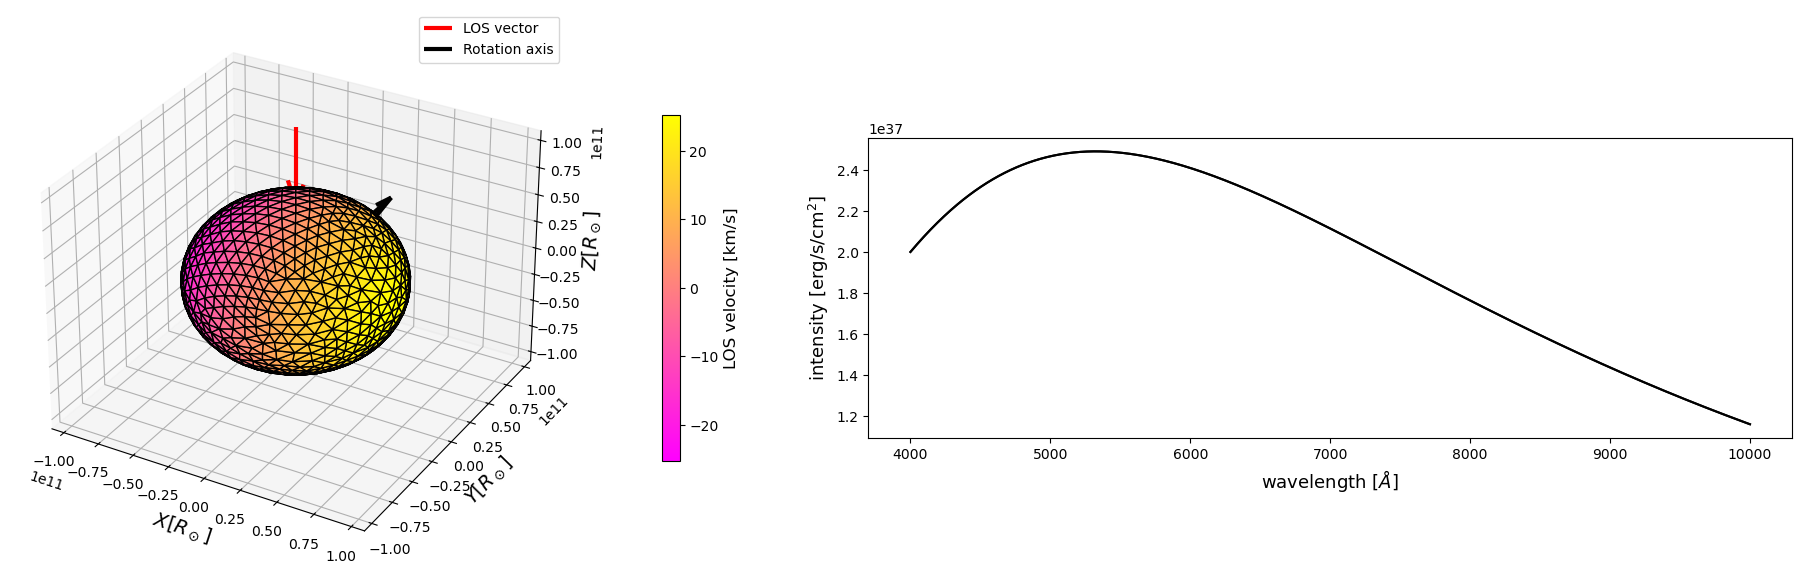

In [17]:
from spice.plots import plot_3D_mesh_and_spectrum

_, _, _ = plot_3D_mesh_and_spectrum(pm, wavelengths=ws, spectrum=s, mesh_plot_kwargs=dict(property='los_velocities', cmap='spring'))